In [30]:
%pip install tensorflow==2.12.1

DEPRECATION: Loading egg at c:\python 37\lib\site-packages\chatbotai-0.3.1.3-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\python 37\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [31]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

In [33]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.1


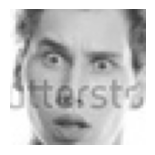

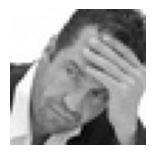

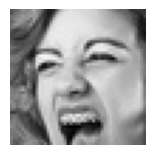

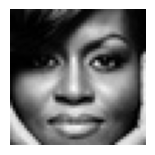

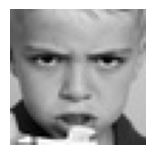

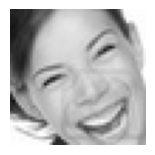

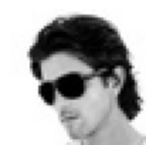

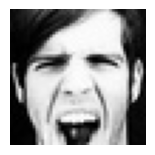

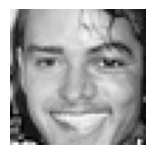

In [34]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(8,6))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [35]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(
    'train/',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_train.flow_from_directory(
    'test/',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [36]:
def CNN_layer(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,center=True,scale=True)(x)  #to remove overfitting
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)        #to remove overfitting
    
    return x

In [37]:
def Dense_layer(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,center=True,scale=True)(x)  #to remove overfitting
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [38]:
def Cnn_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = CNN_layer(inputs,32,(3,3))
    conv_2 = CNN_layer(conv_1,64,(5,5))
    conv_3 = CNN_layer(conv_2,128,(3,3))
    conv_4 = CNN_layer(conv_3,256,(3,3))

    flatten = Flatten()(conv_4)
    
    dense_1 = Dense_layer(flatten,256)
    dense_2 = Dense_layer(dense_1,512)

    output  = Dense(7, activation="softmax")(dense_2)
    model  =  Model(inputs=[inputs],outputs = [output])

    opt = Adam(learning_rate=0.0005)
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = opt , metrics =["accuracy"])

    return model

In [39]:
model = Cnn_model((48,48,1))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0   

In [40]:
epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_weights_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5,min_lr=0.00001)
callbacks = [checkpoint , reduce_lr]

In [41]:
history = model.fit(
          x = train_generator,
          steps_per_epoch = steps_per_epoch,
          epochs = epochs,
          validation_data = validation_generator,
          validation_steps = validation_steps,
          callbacks = callbacks,
          verbose=1,
)

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.8895 - accuracy: 0.2711
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 100s 216ms/step - loss: 1.8895 - accuracy: 0.2711 - val_loss: 1.7383 - val_accuracy: 0.3234 - lr: 5.0000e-04
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.6384 - accuracy: 0.3686
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 97s 216ms/step - loss: 1.6384 - accuracy: 0.3686 - val_loss: 1.5932 - val_accuracy: 0.3994 - lr: 5.0000e-04
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.4950 - accuracy: 0.4198
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 95s 212ms/step - loss: 1.4950 - accuracy: 0.4198 - val_loss: 1.5557 - val_accuracy: 0.4180 - lr: 5.0000e-04
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.3978 - accuracy: 0.4616
Epoch 4: saving model to model_weigh

In [42]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 49ms/step - loss: 0.9569 - accuracy: 0.6484


[0.9568617939949036, 0.6483700275421143]

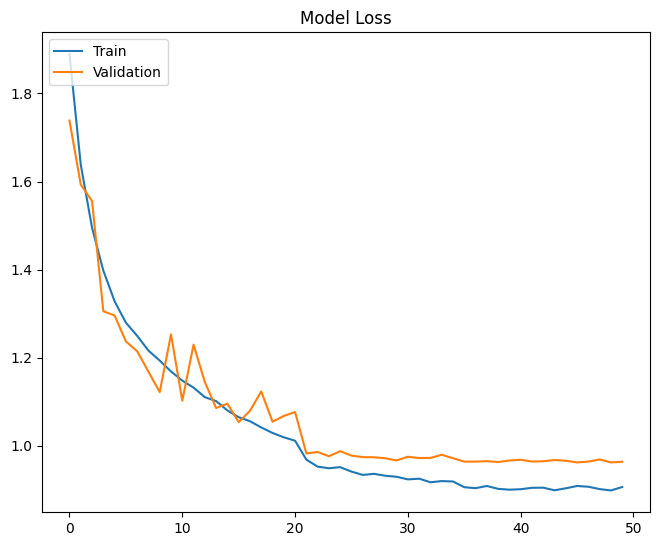

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

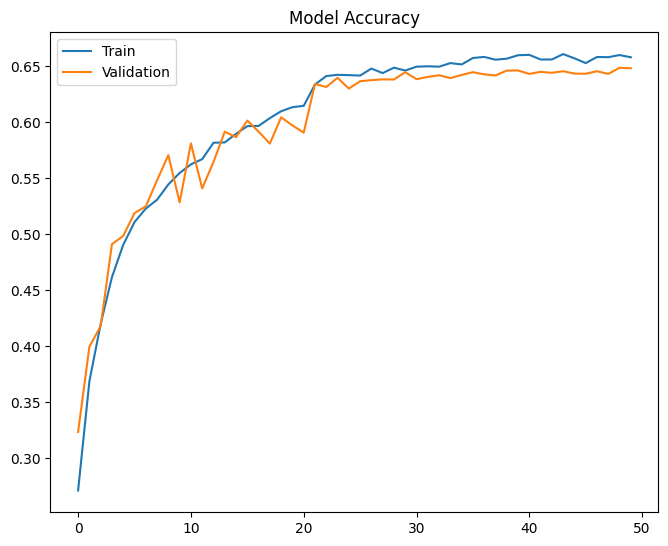

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [45]:
model_json = model.to_json()
with open('model_emo.json', 'w') as json_file:
          json_file.write(model_json)